<a href="https://colab.research.google.com/github/DrJHSIM/App_timeseries/blob/main/20241202_bitcoin_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

- DATASETS

  https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [2]:
df = pd.read_csv("/content/btcusd_1-min_data.csv")

In [3]:
df = df.iloc[:,[0,4]]

In [4]:
date_time = pd.to_datetime(df.pop('Timestamp'), unit = 's')
date_time
# 2012-01-02 00:00 ~ 23:59의 데이터로 2012-01-03 00:00의 종가를 예측.

,Timestamp
0,2012-01-01 10:01:00
1,2012-01-01 10:02:00
2,2012-01-01 10:03:00
3,2012-01-01 10:04:00
4,2012-01-01 10:05:00
...,...
742289,2013-05-30 22:30:00
742290,2013-05-30 22:31:00
742291,2013-05-30 22:32:00
742292,2013-05-30 22:33:00


In [5]:
#2012-01-01 00:00:00 시작에서 다음 날 2012-01-03 00: 시작가 기준. 데이터 분단위.
bit_df = df[60*14-1::60]

In [6]:
date_time = date_time[60*14-1::60]

In [7]:
#정상적인 데이터 2012-02-06 00:00:00 부터 2024-11-26 00:00:00까지 진행
date_time = date_time.iloc[60*14:-33]

In [8]:
bit_df = bit_df[60*14:-33]

데이터가 중간에 바져서 품질이 좋지 않은 것을 확인.
우선, 샘플 데이터로 1시간 간격으로 진행.

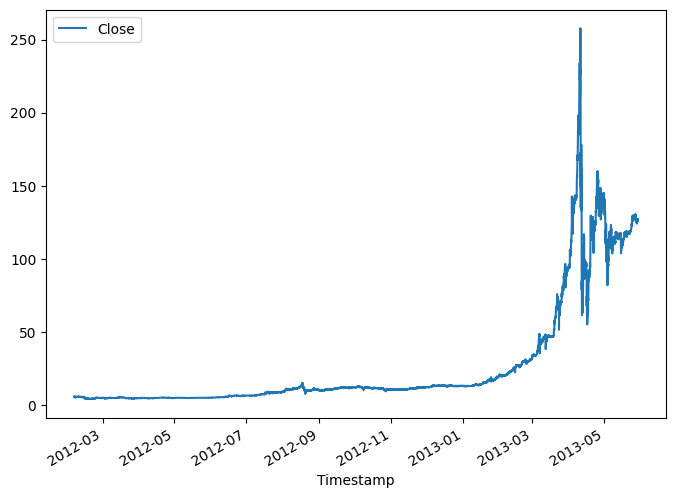

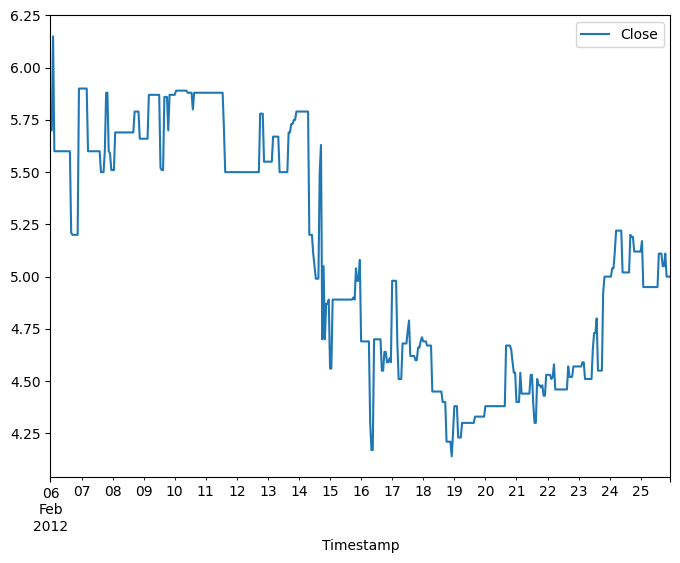

In [9]:
plot_cols = ['Close']
plot_features = bit_df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = bit_df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [ ]:
# '''
# chatgpt
# '''
# # 예시 데이터프레임
# # data = {
# #     'Timestamp': [1.325412e+09, 1.325412e+09],
# #     'Open': [4.58, 4.58],
# #     'High': [4.58, 4.58],
# #     'Low': [4.58, 4.58],
# #     'Close': [4.58, 4.58],
# #     'Volume': [0.0, 0.0]
# # }

# df['Timestamp'] = pd.DataFrame(df['Timestamp'])

# # 타임스탬프를 년-월-일-시간-분 형식으로 변환
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')  # 타임스탬프를 datetime 객체로 변환
# df['Formatted_Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M')  # 원하는 형식으로 변환

# # 결과 출력
# print(df[['Timestamp', 'Formatted_Timestamp']])


                  Timestamp Formatted_Timestamp
0       2012-01-01 10:01:00    2012-01-01 10:01
1       2012-01-01 10:02:00    2012-01-01 10:02
2       2012-01-01 10:03:00    2012-01-01 10:03
3       2012-01-01 10:04:00    2012-01-01 10:04
4       2012-01-01 10:05:00    2012-01-01 10:05
...                     ...                 ...
6721276 2024-11-29 23:57:00    2024-11-29 23:57
6721277 2024-11-29 23:58:00    2024-11-29 23:58
6721278 2024-11-29 23:59:00    2024-11-29 23:59
6721279 2024-11-30 00:00:00    2024-11-30 00:00
6721280                 NaT                 NaN

[6721281 rows x 2 columns]


In [10]:
bit_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,11485.0,26.95632,39.124785,4.14,5.55,11.4,19.05,257.7


### Split the data

In [11]:
column_indices = {name: i for i, name in enumerate(bit_df.columns)}

n = len(bit_df)
train_df = bit_df[0:int(n*0.7)]
val_df = bit_df[int(n*0.7):int(n*0.9)]
test_df = bit_df[int(n*0.9):]

num_features = bit_df.shape[1]

In [12]:
test_df.head(2)

,Close
671399,144.50
671459,114.17


### 데이터 정규화 (Normalize the Data)
신경망을 학습시키기 전에 특성을 스케일링하는 것이 중요합니다. 정규화(Normalization)는 이러한 스케일링을 수행하는 일반적인 방법 중 하나로, 각 특성에서 평균을 빼고 표준 편차로 나누어 데이터를 변환합니다.

평균(mean)과 표준 편차(standard deviation)는 훈련 데이터만을 사용하여 계산해야 하며, 이는 모델이 검증 및 테스트 세트의 값에 접근할 수 없도록 하기 위함입니다.

훈련 중에는 모델이 훈련 세트에서 미래 값에 접근해서는 안 되며, 이 정규화(normalization)는 이동 평균(moving averages)을 사용하여 수행되어야 한다는 주장도 가능합니다. 그러나 이것은 이 튜토리얼의 초점이 아니며, 검증 및 테스트 세트를 통해 비교적 정직한 평가 지표를 얻을 수 있습니다. 따라서 간단함을 위해 이 튜토리얼에서는 단순 평균(simple average)을 사용합니다.








In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [14]:
val_df.head(2)

,Close
533579,1.427909
533639,1.393900


여기서 val_df['Close']이 nan임을 확인.

'''
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-64-5ea621e8f36e> in <cell line: 8>()
      6 val_performance = {}
      7 performance = {}
----> 8 val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
      9 performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

21 frames
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py in _create_c_op(graph, node_def, inputs, control_inputs, op_def, extract_traceback)
   1035   except errors.InvalidArgumentError as e:
   1036     # Convert to ValueError for backwards compatibility.
-> 1037     raise ValueError(e.message)
   1038
   1039   # Record the current Python stack trace as the creating stacktrace of this

ValueError: in user code:

    File "<ipython-input-45-3603dd900e3b>", line 2, in split_window  *
        inputs = features[:, self.input_slice, :]

    ValueError: Index out of range using input dim 2; input has only 2 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=5, ellipsis_mask=0, end_mask=5, new_axis_mask=0, shrink_axis_mask=0](args_0, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [?,?], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.
'''

<ipython-input-15-87f2f16c48c7>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(bit_df.keys(), rotation=90)


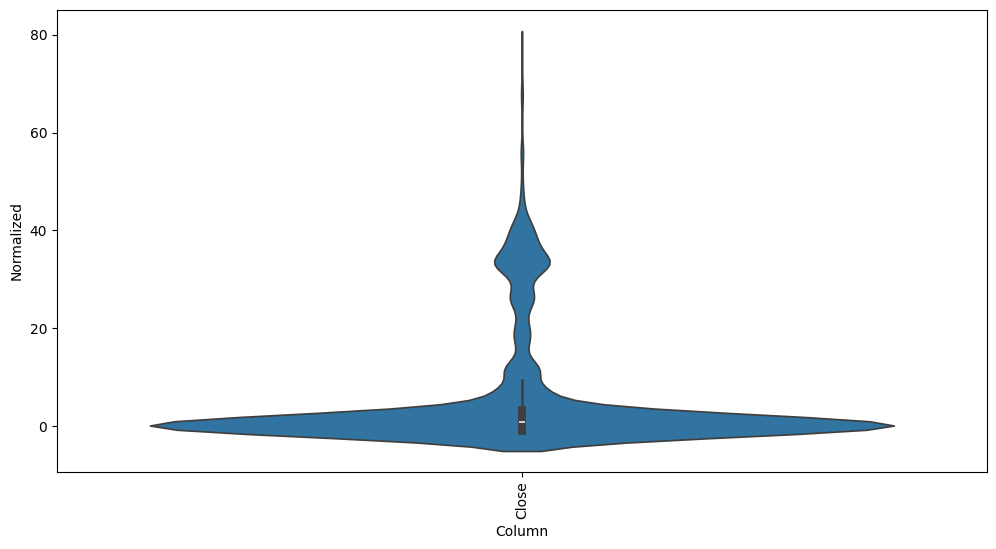

In [15]:
df_std = (bit_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(bit_df.keys(), rotation=90)

## 데이터 윈도우링 (Data Windowing)
이 튜토리얼의 모델들은 데이터에서 연속된 샘플 윈도우(window)를 기반으로 일련의 예측을 수행합니다.

입력 윈도우의 주요 특징은 다음과 같습니다:

입력 및 레이블 윈도우의 너비(시간 단계의 개수).
입력과 레이블 사이의 시간 오프셋(offset).
어떤 특성이 입력 또는 레이블, 또는 둘 다로 사용되는지.
이 튜토리얼에서는 다양한 모델(선형 모델, DNN, CNN, RNN)을 구축하며, 이를 다음과 같은 작업에 사용합니다:

단일 출력(single-output) 및 다중 출력(multi-output) 예측.
단일 시간 단계(single-time-step) 및 다중 시간 단계(multi-time-step) 예측.
이 섹션에서는 모든 모델에서 재사용할 수 있도록 데이터 윈도우링을 구현하는 데 중점을 둡니다.








작업과 모델의 유형에 따라 다양한 데이터 윈도우를 생성해야 할 수 있습니다. 다음은 몇 가지 예입니다:

1. 예를 들어, 24시간의 기록을 기반으로 24시간 후의 단일 예측을 수행하려면 다음과 같은 윈도우를 정의할 수 있습니다:
  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2.6시간의 기록을 기반으로 1시간 후의 단일 예측을 수행하는 모델은 다음과 같은 윈도우가 필요합니다:
  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)








이 섹션의 나머지 부분에서는 WindowGenerator 클래스를 정의합니다. 이 클래스는 다음과 같은 작업을 수행할 수 있습니다:

1. 위의 다이어그램에서 설명한 대로 인덱스와 오프셋을 처리합니다.
2. 특성 윈도우를 (features, labels) 쌍으로 분리합니다.
3. 결과 윈도우의 내용을 시각화합니다.
4. tf.data.Dataset을 사용하여 학습, 평가, 테스트 데이터에서 이러한 윈도우의 배치를 효율적으로 생성합니다.


### 1. 인덱스와 오프셋 (Indexes and Offsets)
먼저 WindowGenerator 클래스를 생성합니다. 이 클래스의 __init__ 메서드에는 입력 및 레이블 인덱스에 필요한 모든 로직이 포함됩니다.

또한, 이 메서드는 훈련(Training), 평가(Evaluation), **테스트(Test)**용 DataFrame을 입력으로 받습니다. 이러한 DataFrame은 이후에 윈도우 형태의 tf.data.Dataset으로 변환됩니다.

In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

다음은 이 섹션의 시작 부분에 표시된 다이어그램의 두 윈도우를 생성하는 코드입니다:








In [17]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['Close'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Close']

In [18]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Close']

### 2. 분리 (Split)
연속된 입력 목록이 주어지면, split_window 메서드는 이를 입력 윈도우와 레이블 윈도우로 변환합니다.

앞서 정의한 예제 w2는 다음과 같이 분리됩니다:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)



이 다이어그램은 데이터의 features 축을 보여주지는 않지만, 이 split_window 함수는 label_columns도 처리하므로 단일 출력(single output) 및 다중 출력(multi-output) 예제 모두에 사용할 수 있습니다.








In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [20]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


일반적으로 TensorFlow에서 데이터는 배열로 패킹되며, 가장 바깥쪽 인덱스는 예제 간의 차원을 나타냅니다("배치" 차원). 중간 인덱스는 "시간" 또는 "공간"(너비, 높이) 차원입니다. 가장 안쪽 인덱스는 특성(features)을 나타냅니다.

위 코드는 19개의 특성이 있는 7-타임스텝 윈도우 3개의 배치를 가져왔습니다. 그런 다음 이를 6-타임스텝 19-특성 입력과 1-타임스텝 1-특성 레이블 배치로 분리했습니다. 레이블에 하나의 특성만 포함된 이유는 WindowGenerator가 label_columns=['T (degC)']로 초기화되었기 때문입니다. 초기 단계에서 이 튜토리얼은 단일 출력 레이블(single output labels)을 예측하는 모델을 구축합니다.








### 3. 플롯 (Plot)
다음은 분리된 윈도우를 간단히 시각화할 수 있는 플롯 메서드입니다:

In [21]:
w2.example = example_inputs, example_labels

In [22]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

이 플롯은 항목이 참조하는 시간에 따라 입력, 레이블, 그리고 (나중에 추가될) 예측값을 정렬합니다.








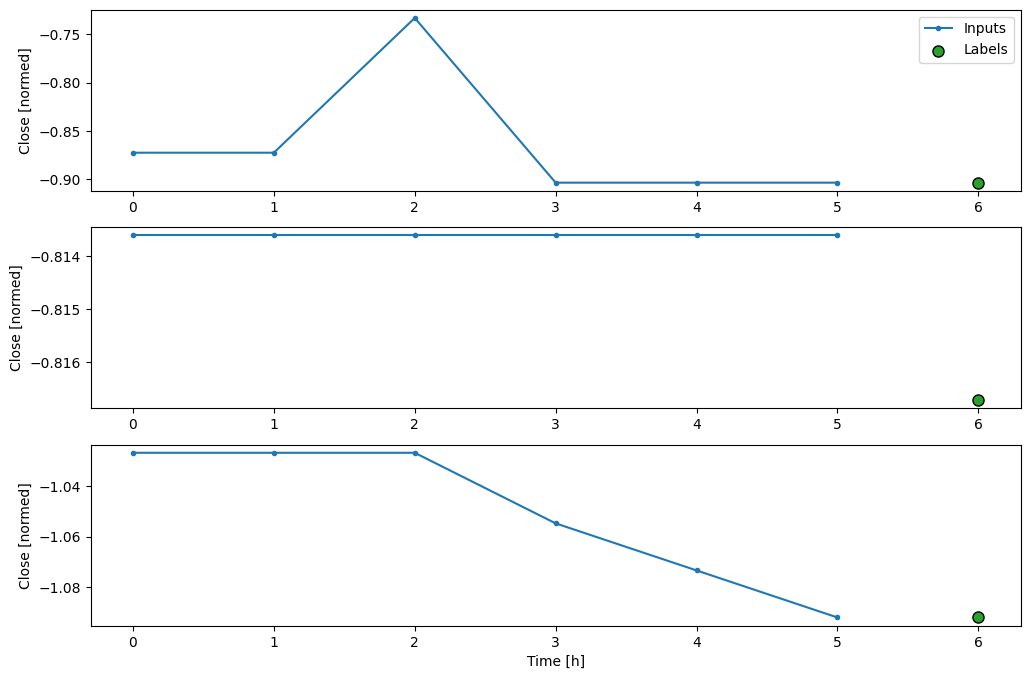

In [23]:
w2.plot()

### 4. Create `tf.data.Dataset`s

마지막으로, 이 make_dataset 메서드는 시계열 데이터프레임(DataFrame)을 받아서 tf.keras.utils.timeseries_dataset_from_array 함수를 사용하여 (입력 윈도우, 레이블 윈도우) 쌍으로 이루어진 tf.data.Dataset으로 변환합니다:








In [24]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

WindowGenerator 객체는 훈련 데이터, 검증 데이터, 테스트 데이터를 보유합니다.

이전에 정의한 make_dataset 메서드를 사용하여 이를 tf.data.Dataset으로 접근할 수 있는 속성을 추가하세요. 또한, 쉽게 접근하고 플롯을 위해 사용할 표준 예제 배치(example batch)도 추가하세요.

In [25]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

이제 WindowGenerator 객체를 통해 tf.data.Dataset 객체에 접근할 수 있으므로 데이터를 쉽게 반복(iterate)할 수 있습니다.

Dataset.element_spec 속성은 데이터셋 요소의 구조, 데이터 유형, 그리고 모양을 알려줍니다.








In [26]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Dataset을 반복(iterate)하면 구체적인 배치(batch)가 생성됩니다:








In [27]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


## 단일 단계 모델 (Single Step Models)
이런 유형의 데이터에서 구축할 수 있는 가장 단순한 모델은 현재 조건만을 기반으로 1시간 후(1 타임스텝)의 단일 특성 값을 예측하는 모델입니다.

따라서, T (degC) 값을 1시간 후로 예측하는 모델을 구축하는 것부터 시작하세요.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

이 단일 단계 (input, label) 쌍을 생성하도록 WindowGenerator 객체를 구성하세요.








In [28]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Close']

window 객체는 훈련, 검증, 테스트 세트로부터 tf.data.Dataset을 생성하며, 이를 통해 데이터 배치를 쉽게 반복(iterate)할 수 있습니다.








In [29]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


### 기준선 (Baseline)
훈련 가능한 모델을 구축하기 전에, 나중에 더 복잡한 모델과 비교할 수 있는 성능 기준선(baseline)을 마련하는 것이 좋습니다.

첫 번째 작업은 현재 모든 특성 값을 기반으로 1시간 후의 온도를 예측하는 것입니다. 여기에는 현재 온도 값도 포함됩니다.

따라서, 단순히 현재 온도를 예측값으로 반환하며 "변화 없음(No change)"을 예측하는 모델부터 시작하세요. 이는 온도가 천천히 변하기 때문에 합리적인 기준선이 됩니다. 물론, 예측 시점이 더 먼 미래로 이동하면 이 기준선은 덜 효과적일 것입니다.










In [30]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [31]:
baseline = Baseline(label_index=column_indices['Close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3977 - mean_absolute_error: 0.1911


그 출력은 몇 가지 성능 지표를 보여주었지만, 모델이 얼마나 잘 작동하는지에 대한 감각을 제공하지는 않습니다.

WindowGenerator에는 플롯 메서드가 있지만, 단일 샘플만으로는 흥미로운 플롯을 생성하지 못할 것입니다.

따라서, 24시간 연속된 입력과 레이블 윈도우를 한 번에 생성하는 더 넓은 WindowGenerator를 만드세요. 새로운 wide_window 변수는 모델의 작동 방식을 변경하지 않습니다. 모델은 여전히 단일 입력 시간 단계에 기반하여 1시간 후를 예측합니다. 여기서 time 축은 batch 축처럼 작동하며, 각 예측은 시간 단계 간의 상호작용 없이 독립적으로 이루어집니다.








In [32]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Close']

이 확장된 윈도우는 코드를 변경하지 않고 동일한 baseline 모델에 직접 전달할 수 있습니다. 이는 입력과 레이블이 동일한 시간 단계를 가지며, 기준선 모델(baseline)이 단순히 입력을 출력으로 전달하기 때문입니다:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)







In [33]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


기준선 모델(baseline)의 예측값을 플롯하면, 그것이 단순히 레이블을 1시간 뒤로 이동시킨 것임을 알 수 있습니다:








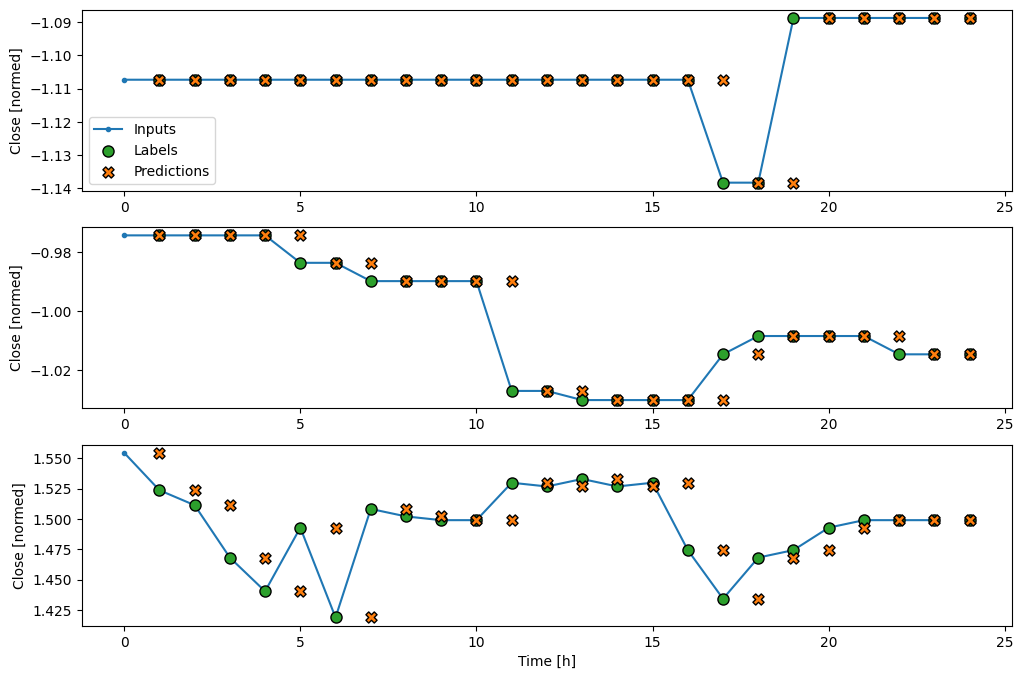

In [34]:
wide_window.plot(baseline)

위의 세 가지 예제 플롯에서 단일 단계 모델(single step model)은 24시간 동안 실행되었습니다. 이는 다음과 같이 설명할 수 있습니다:

파란색 Inputs 선은 각 시간 단계에서 입력 온도를 보여줍니다. 모델은 모든 특성을 입력으로 받지만, 이 플롯은 온도만 표시합니다.
초록색 Labels 점은 목표 예측 값을 보여줍니다. 이 점들은 입력 시점이 아닌 예측 시점에 표시됩니다. 그래서 레이블 범위가 입력값에 비해 1단계 이동된 것입니다.
주황색 Predictions 십자는 각 출력 시간 단계에서 모델의 예측을 나타냅니다. 모델이 완벽하게 예측한다면, 예측값은 **Labels**에 정확히 겹쳐져야 합니다.







### 선형 모델 (Linear Model)
이 작업에 적용할 수 있는 가장 간단한 학습 가능한(trainable) 모델은 입력과 출력 사이에 선형 변환을 삽입하는 것입니다. 이 경우, 특정 시간 단계의 출력은 오직 해당 단계에만 의존합니다:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

tf.keras.layers.Dense 레이어에서 activation이 설정되지 않은 경우, 이는 선형 모델입니다. 이 레이어는 데이터의 마지막 축을 (batch, time, inputs)에서 (batch, time, units)로 변환하기만 하며, batch 및 time 축 전체에 독립적으로 적용됩니다.

In [35]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [36]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


이 튜토리얼에서는 여러 모델을 학습시키므로, 학습 절차를 함수로 묶어 패키지화하세요:








In [37]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

모델을 학습시키고 성능을 평가하세요:

In [38]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.8860 - mean_absolute_error: 2.0819 - val_loss: 1324.7228 - val_mean_absolute_error: 24.0524
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.8586 - mean_absolute_error: 1.8485 - val_loss: 1039.7365 - val_mean_absolute_error: 21.3102
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0186 - mean_absolute_error: 1.6358 - val_loss: 803.0070 - val_mean_absolute_error: 18.7284
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3179 - mean_absolute_error: 1.4331 - val_loss: 608.5937 - val_mean_absolute_error: 16.3049
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7448 - mean_absolute_error: 1.2428 - val_loss: 451.1360 - val_mean_absolute_error: 14.0375
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2886 - mean_absolute_error: 1.0679 - val_loss: 326.0210 - val_mean_absolute_error: 11.9330
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9248 - mean_absol

baseline 모델과 마찬가지로, 선형 모델(linear model)도 넓은 윈도우(batch of wide windows)에 대해 호출할 수 있습니다. 이 방식으로 사용하면 모델은 연속된 시간 단계에서 독립적인 예측 세트를 수행합니다.

이때 time 축은 또 다른 batch 축처럼 작동합니다. 각 시간 단계에서의 예측 간에는 상호작용이 없습니다.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)








In [39]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


다음은 wide_window에서 예제 예측의 플롯입니다. 많은 경우 예측이 단순히 입력 온도를 반환하는 것보다 명확히 더 나은 결과를 보이지만, 일부 경우에는 더 나쁜 결과를 보이기도 합니다:








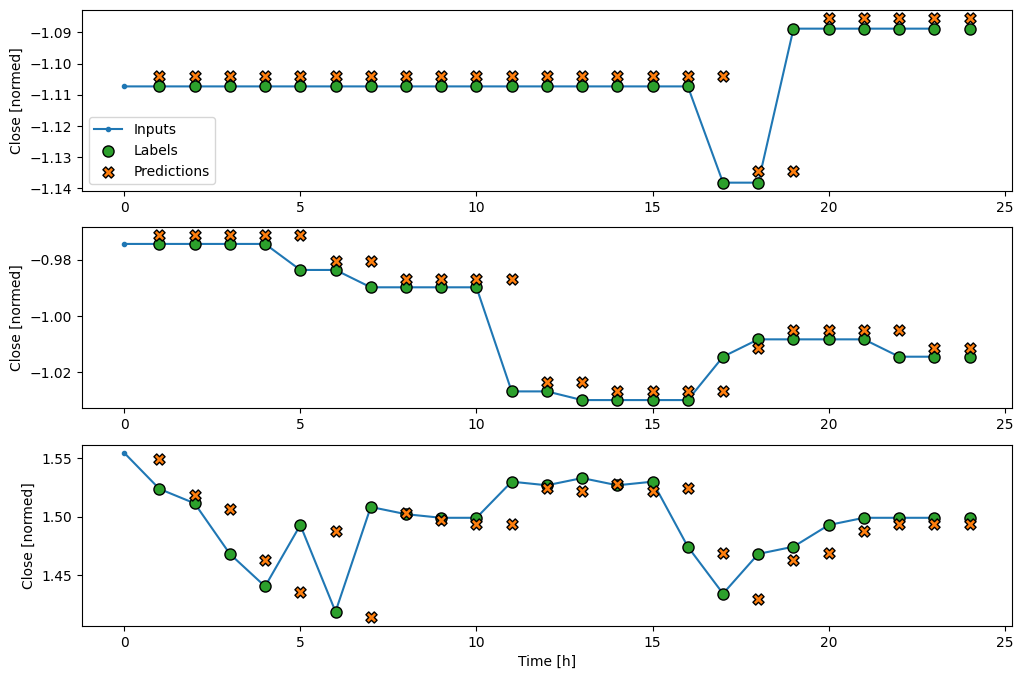

In [40]:
wide_window.plot(linear)

선형 모델의 한 가지 장점은 비교적 해석하기 쉽다는 점입니다.
레이어의 가중치를 추출하여 각 입력에 할당된 가중치를 시각화할 수 있습니다:








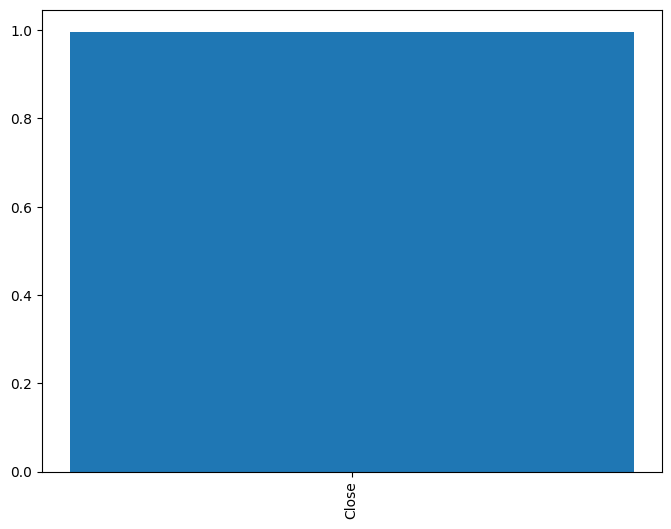

In [41]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


가끔 모델이 입력 값 T (degC)에 가장 큰 가중치를 두지 않는 경우도 있습니다. 이는 랜덤 초기화(random initialization)의 위험 중 하나입니다.

### Dense
여러 시간 단계를 실제로 처리하는 모델을 적용하기 전에, 더 깊고 강력한 단일 입력 단계(single input step) 모델의 성능을 확인할 가치가 있습니다.

다음은 linear 모델과 유사한 모델이지만, 입력과 출력 사이에 여러 개의 Dense 레이어를 쌓은 모델입니다:








In [42]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1562 - mean_absolute_error: 0.2292 - val_loss: 2.5381 - val_mean_absolute_error: 0.8887
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0192 - val_loss: 2.3463 - val_mean_absolute_error: 0.8475
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0188 - val_loss: 2.0254 - val_mean_absolute_error: 0.7667
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mean_absolute_error: 0.0184 - val_loss: 2.5087 - val_mean_absolute_error: 0.8856
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mean_absolute_error: 0.0183 - val_loss: 2.3808 - val_mean_absolute_error: 0.8574
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8949 - mean_absolute_error: 0.9115


#### converting to .tflite
- https://ai.google.dev/edge/litert/models/convert_tf


In [ ]:
# (to generate a SavedModel) tf.saved_model.save(model, "saved_model_keras_dir")
tf.saved_model.save(dense, "saved_model_keras_dir")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(dense)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

### 다단계 Dense 모델 (Multi-step Dense)
단일 시간 단계 모델(single-time-step model)은 입력 값의 현재 상태에 대한 맥락(context)을 알 수 없습니다. 즉, 입력 특성이 시간이 지남에 따라 어떻게 변화하는지를 볼 수 없습니다. 이 문제를 해결하려면, 모델이 예측 시 여러 시간 단계를 참조할 수 있어야 합니다:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)







baseline, linear, dense 모델은 각 시간 단계를 독립적으로 처리했습니다. 여기에서는 모델이 여러 시간 단계를 입력으로 받아 단일 출력을 생성합니다.

3시간 입력과 1시간 레이블 배치를 생성하는 WindowGenerator를 만드세요:

Window의 shift 매개변수는 두 윈도우의 끝부분을 기준으로 합니다.








In [43]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Close']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

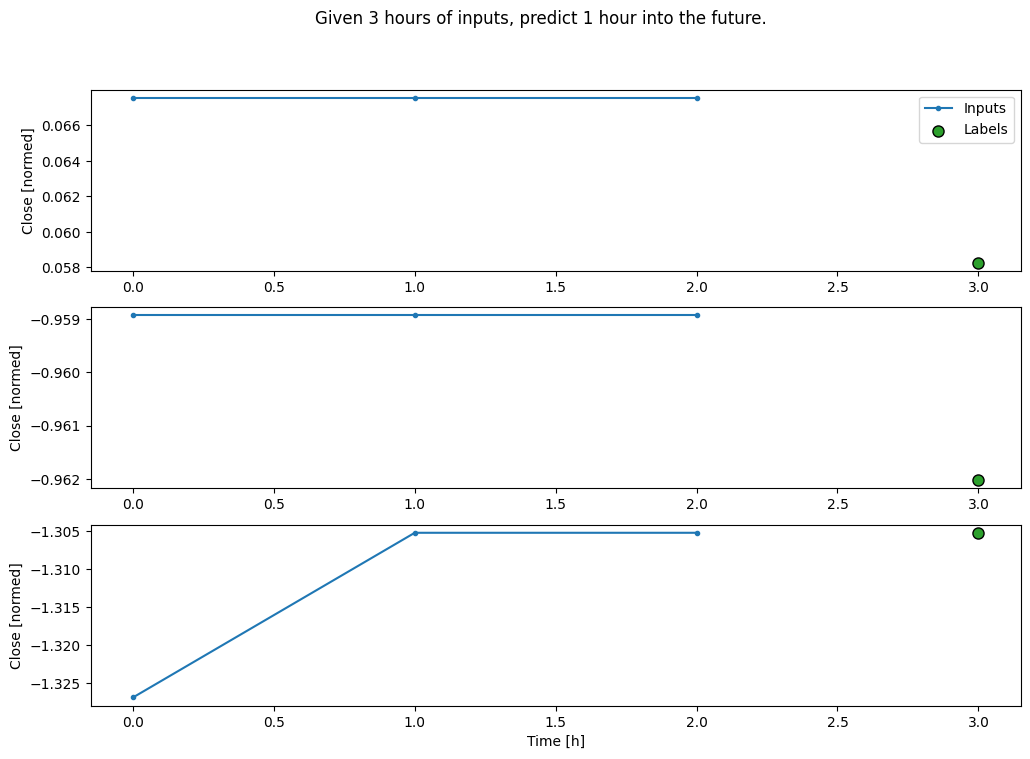

In [44]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

여러 입력 단계가 있는 윈도우에서 dense 모델을 학습하려면, 모델의 첫 번째 레이어로 tf.keras.layers.Flatten을 추가할 수 있습니다:








In [45]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [46]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [47]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7028 - mean_absolute_error: 0.3196


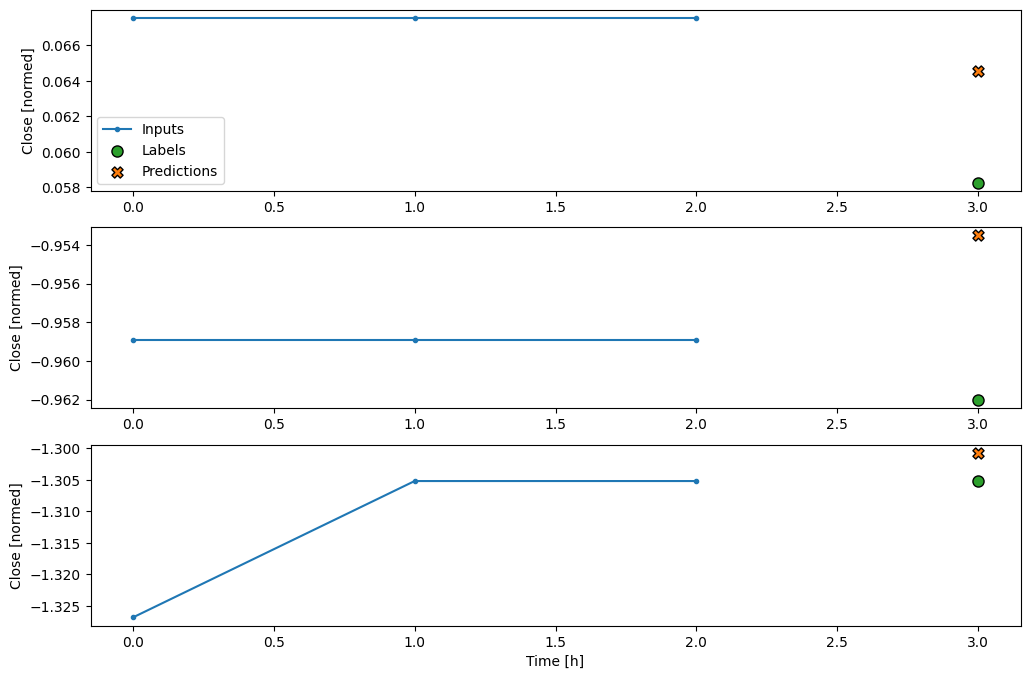

In [48]:
conv_window.plot(multi_step_dense)

이 접근 방식의 주요 단점은 생성된 모델이 정확히 이 형태의 입력 윈도우에서만 실행될 수 있다는 점입니다.








In [49]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 1)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (32, 24)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 1), dtype=float32)
  • training=None
  • mask=None


다음 섹션의 컨볼루션 모델은 이 문제를 해결합니다.








### 합성곱 신경망 (Convolution Neural Network)
합성곱 레이어(tf.keras.layers.Conv1D)도 각 예측에 대해 여러 시간 단계를 입력으로 받습니다.








아래는 multi_step_dense와 동일한 모델을 합성곱으로 다시 작성한 것입니다.

변경 사항은 다음과 같습니다:

tf.keras.layers.Flatten과 첫 번째 tf.keras.layers.Dense가 tf.keras.layers.Conv1D로 대체되었습니다.
합성곱이 출력에서 시간 축을 유지하기 때문에 tf.keras.layers.Reshape는 더 이상 필요하지 않습니다.







In [50]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

예제 배치에서 실행하여 모델이 예상된 형태의 출력을 생성하는지 확인하세요:








In [51]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


conv_window에서 학습 및 평가를 수행하면 multi_step_dense 모델과 유사한 성능을 보여야 합니다.








In [52]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9573 - mean_absolute_error: 0.7419


이 conv_model과 multi_step_dense 모델의 차이점은 conv_model이 임의의 길이를 가진 입력에서 실행할 수 있다는 점입니다. 합성곱 레이어는 입력의 슬라이딩 윈도우(sliding window)에 적용됩니다:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)


더 넓은 입력에서 실행하면, 더 넓은 출력을 생성합니다:








In [53]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)



출력이 입력보다 짧다는 점에 유의하세요. 학습 또는 플롯 작업을 수행하려면 레이블과 예측의 길이가 동일해야 합니다. 따라서, 레이블과 예측의 길이를 맞추기 위해 약간 더 많은 입력 시간 단계를 포함하는 넓은 윈도우를 생성하는 WindowGenerator를 만드세요:

In [54]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Close'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Close']

In [55]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


이제 더 넓은 윈도우에서 모델의 예측을 플롯할 수 있습니다. 첫 번째 예측 전에 3개의 입력 시간 단계가 있음을 유의하세요. 여기서 각 예측은 이전 3개의 시간 단계를 기반으로 합니다.








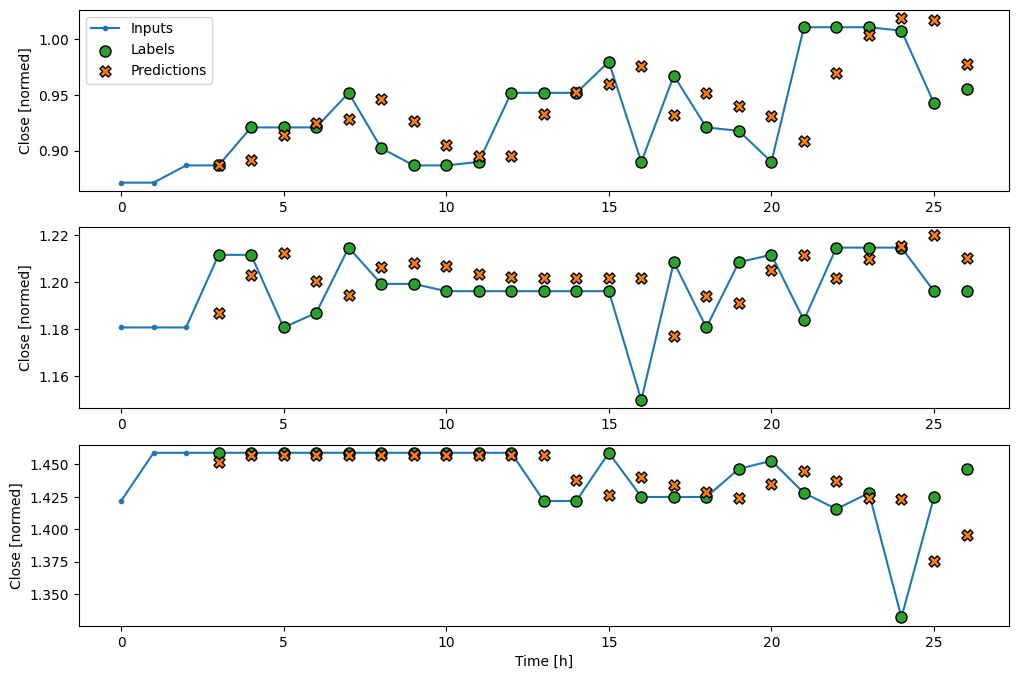

In [56]:
wide_conv_window.plot(conv_model)

### 순환 신경망 (Recurrent Neural Network)
순환 신경망(RNN, Recurrent Neural Network)은 시계열 데이터에 적합한 신경망 유형입니다. RNN은 시계열 데이터를 단계별로 처리하며, 각 시간 단계에서 내부 상태를 유지합니다.

[Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) 튜토리얼과 [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) 가이드를 통해 자세히 알아볼 수 있습니다.

이 튜토리얼에서는 Long Short-Term Memory(tf.keras.layers.LSTM)라는 RNN 레이어를 사용할 것입니다.








Keras RNN 레이어(예: tf.keras.layers.LSTM)의 중요한 생성자 인수 중 하나는 return_sequences 인수입니다. 이 설정은 레이어를 다음 두 가지 방식으로 구성할 수 있습니다:

1. **False(기본값)**인 경우, 레이어는 마지막 시간 단계의 출력만 반환하며, 모델이 내부 상태를 준비(warm up)한 후 단일 예측을 수행할 수 있도록 합니다:
![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)


2. **True**인 경우, 레이어는 각 입력에 대해 출력을 반환합니다. 이는 다음과 같은 경우에 유용합니다:
RNN 레이어를 쌓을 때.
여러 시간 단계를 동시에 학습할 때.


![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)






lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [57]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

return_sequences=True로 설정하면 모델은 한 번에 24시간의 데이터를 학습할 수 있습니다.

참고: 이는 모델 성능에 대해 비관적인 관점을 제공합니다. 첫 번째 시간 단계에서는 모델이 이전 단계에 접근할 수 없으므로, 앞서 보여준 단순한 linear 및 dense 모델보다 나은 성능을 낼 수 없습니다.








In [58]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [59]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 246.4363 - mean_absolute_error: 8.4936


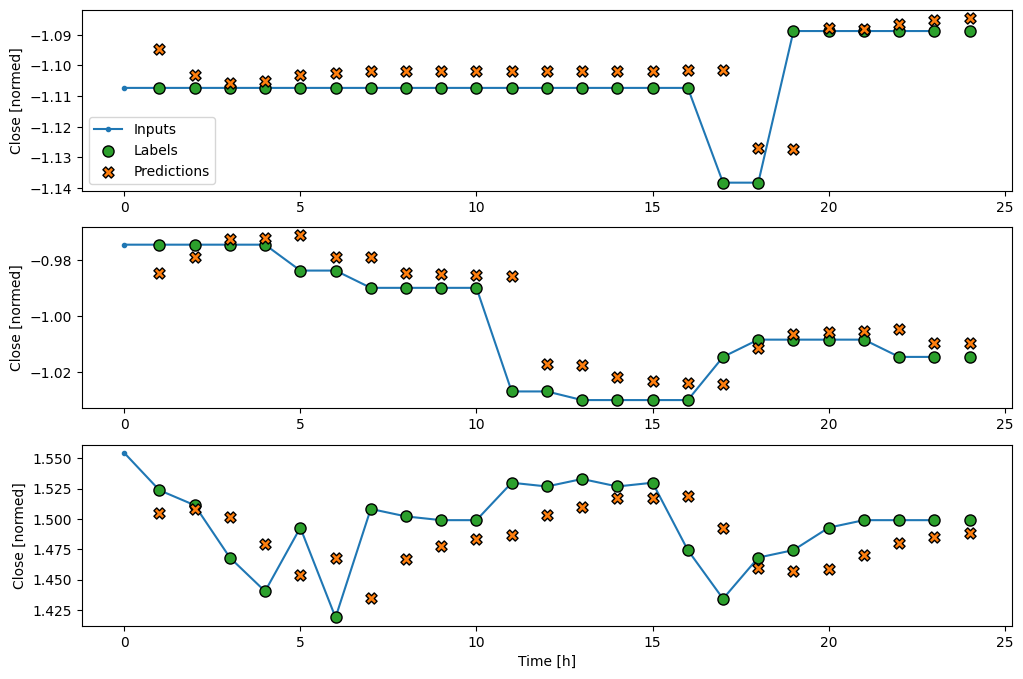

In [60]:
wide_window.plot(lstm_model)

### Performance

이 데이터셋에서는 일반적으로 각 모델이 이전 모델보다 약간 더 나은 성능을 보입니다.








In [61]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [62]:
val_performance

{'Baseline': {'loss': 0.5852342247962952,
  'mean_absolute_error': 0.20416659116744995},
 'Linear': {'loss': 0.5900874137878418,
  'mean_absolute_error': 0.21742773056030273},
 'Dense': {'loss': 2.3807709217071533,
  'mean_absolute_error': 0.8573794364929199},
 'Multi step dense': {'loss': 0.7612281441688538,
  'mean_absolute_error': 0.31149476766586304},
 'Conv': {'loss': 1.8791059255599976,
  'mean_absolute_error': 0.7061768770217896},
 'LSTM': {'loss': 228.1362762451172, 'mean_absolute_error': 8.189468383789062}}

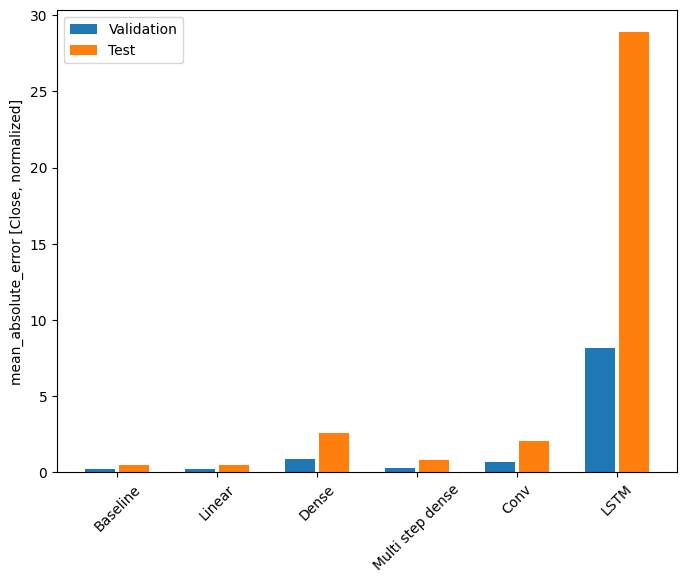

In [63]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [64]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.4853
Linear      : 0.5152
Dense       : 2.5589
Multi step dense: 0.7882
Conv        : 2.0598
LSTM        : 28.8731
